In [1]:
# venv
import torch
import datetime as dt
print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

2.0.1+cu117
GPU is available.


In [2]:
import os, subprocess, glob
from shutil import rmtree
import cv2
import demoTalkNetMod
import logging
import os
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import srt
import whisper

from stable_whisper import modify_model
from pyannote.core import Segment, Annotation
from pyannote.core import notebook
import matplotlib.pyplot as plt

logger = logging.getLogger("transcribe")
# sys.path.append(os.path.abspath("TalkNet-ASD/"))

In [3]:
def create_annotation_plot(speaker_timelines):
    custom_diarization = Annotation()
    
    for speaker_key in speaker_timelines.keys():
        for timeline in speaker_timelines[speaker_key]:
            custom_diarization[Segment(timeline[0], timeline[1])] = speaker_key

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot the custom diarization result
    notebook.plot_annotation(custom_diarization, ax, legend=True)

    # Customize the plot (if needed)
    ax.set_xlabel('Time')
    ax.set_yticks([])  # To hide the y-axis

    # Save the figure
#     fig.savefig('custom_diarization_plot.png', bbox_inches='tight')

    # Show the figure (optional)
    plt.show()



def get_openai_model(model_name="base"):
    # initialize model
    logging.info(f"Initializing openai's '{model_name} 'model")
    if model_name in [
        "tiny.en",
        "tiny",
        "base.en",
        "base",
        "small.en",
        "small",
        "medium.en",
        "medium",
        "large",
    ]:
        try:
            model = whisper.load_model(model_name)
            # Using the stable whisper to modifiy the model for better timestamps accuracy
            modify_model(model)
            logging.info("Model was successfully initialized")
        except:
            logging.error("Unable to initialize openai model")
            return None
    else:
        logging.error(
            "Model  not found; available models = ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']"
        )
        return None

    return model


def generate_openai_transcription(file_path, model):
    logging.info(f"Generating transcription for file - {file_path}")

    decode_options = dict(language="en")
    transcribe_options = dict(task="transcribe", **decode_options)
    output = model.transcribe(file_path, **transcribe_options)

    transcriptions = {}

    for num, s in enumerate(output.segments):
        transcriptions[num] = []
        for word in s.words:
            transcriptions[num].append(
                {
                    "text": s.text,
                    "segment_start": s.start,
                    "segment_end": s.end,
                    "word": word.word,
                    "word_start": word.start,
                    "word_end": word.end,
                }
            )

    rows = []

    for key, words in transcriptions.items():
        for word in words:
            row = {
                "segment_id": key,
                "segment_text": word["text"],
                "segment_start": word["segment_start"],
                "segment_end": word["segment_end"],
                "word": word["word"],
                "word_start": word["word_start"],
                "word_end": word["word_end"],
            }
            rows.append(row)

    df = pd.DataFrame(rows)

    return df


def find_overlap(intervals1, intervals2):
    overlap = 0
    total_duration1 = 0
    total_duration2 = 0

    # Calculate the total duration of intervals in intervals1
    for start, end in intervals1:
        total_duration1 += end - start

    # Calculate the total duration of intervals in intervals2 and find the overlap
    for start, end in intervals2:
        total_duration2 += end - start
        for s1, e1 in intervals1:
            common_start = max(s1, start)
            common_end = min(e1, end)
            if common_start < common_end:
                overlap += common_end - common_start

    # Calculate the percentage of overlap with respect to intervals1
    percentage_overlap1 = (overlap / total_duration1) * 100

    # Calculate the percentage of overlap with respect to intervals2
    percentage_overlap2 = (overlap / total_duration2) * 100

    return percentage_overlap1, percentage_overlap2


def get_video_to_audio_mapping(video_output, audio_output):
    video_audio_mapping = {}
    for audio_speaker in audio_output.keys():
        for video_speaker in video_output.keys():
            video_overlap, _ = find_overlap(video_output[video_speaker], audio_output[audio_speaker])
            if video_overlap > 80:
                video_audio_mapping[audio_speaker] = video_speaker
                break
    return video_audio_mapping

def get_segment_to_speaker_mapping(segment_start, segment_end, speaker_mapping, audio_output):
    
    final_speaker = None
    max_overlap = 0
    
    for audio_speaker in audio_output.keys():
        segment_overlap, _ = find_overlap([(segment_start, segment_end)], audio_output[audio_speaker])
        if segment_overlap > max_overlap:
            final_speaker = audio_speaker
            max_overlap = segment_overlap
            
    if final_speaker is None:
        return "Unknown", max_overlap
    else:
        if final_speaker in speaker_mapping.keys():
            return speaker_mapping[final_speaker], max_overlap
        else:
            return final_speaker, max_overlap

In [4]:
class Args:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

args_dict = {
    "videoName": "Video3",
    "videoFolder":"Videos",
    "pretrainModel":"pretrain_TalkSet.model",
    "nDataLoaderThread":10,
    "facedetScale":0.25,
    "minTrack":10,
    "numFailedDet":10,
    "minFaceSize":1,
    "cropScale":0.40,
    "start":0,
    "duration":0,
    "evalCol":False,
    "colSavePath":"/data08/col",
}

args = Args(args_dict)

if os.path.isfile(args.pretrainModel) == False:  # Download the pretrained model
    Link = "1AbN9fCf9IexMxEKXLQY2KYBlb-IhSEea"
    cmd = "gdown --id %s -O %s" % (Link, args.pretrainModel)
    subprocess.call(cmd, shell=True, stdout=None)

args.videoPath = glob.glob(os.path.join(args.videoFolder, args.videoName + ".*"))[0]
args.savePath = os.path.join(args.videoFolder, args.videoName)
args.audioPath = os.path.join(args.savePath, "pyavi", "audio.wav")
video = cv2.VideoCapture(args.videoPath)
args.frameRate = video.get(cv2.CAP_PROP_FPS)
video.release()
print(args.frameRate)


model_name_openai = "base.en"
model = get_openai_model(model_name_openai)

25.0


In [5]:
vidTracks, scores, args = demoTalkNetMod.preprocess(args)

2024-01-03 23:39:49 Extract the video and save in Videos/Video3/pyavi/video.avi 
2024-01-03 23:39:49 Extract the audio and save in Videos/Video3/pyavi/audio.wav 
2024-01-03 23:39:55 Extract the frames and save in Videos/Video3/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
Videos/Video3/pyavi/video.avi - scenes detected 10
2024-01-03 23:39:59 Scene detection and save in Videos/Video3/pywork 
2024-01-03 23:41:00 Face detection and save in Videos/Video3/pywork 
2024-01-03 23:41:00 Face track and detected 11 tracks 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:26<00:00,  2.41s/it]


01-03 23:41:27 Model para number = 15.01


Model pretrain_TalkSet.model loaded from previous state! 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.87it/s]
2024-01-03 23:41:31 Scores extracted and saved in Videos/Video3/pywork 


In [6]:
df = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [03:22<00:00,  3.20tracks/s]
2024-01-03 23:45:16 Face encoding generation completed

In [7]:
df.to_pickle(f"{args.savePath}/{args.videoName}.pkl")

In [8]:
df = pd.read_pickle(f"{args.savePath}/{args.videoName}.pkl")

In [10]:
# 001 - eps=0.4, min_samples = 4
# PL - eps=0.5, min_samples = 200
# Video3 - eps=0.5, min_samples = 100
# Video2 - eps=0.5, min_samples = 100
# Choose DBSCAN parameters
eps = 0.5
min_samples = 100

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(df["Encoding"].to_list())
unique, counts = np.unique(clusters, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ -1  27]
 [  0 428]
 [  1 195]]


In [11]:
df["Clusters"] = clusters

In [12]:
video_output = demoTalkNetMod.get_final_tracks(df, args)

In [13]:
# video_output = {
#     "SPEAKER_00": [(3.92, 5.64), (6.4, 6.56), (7.32, 12.68), (180.72, 183.44)],
#     "SPEAKER_01": [
#         (32.76, 45.48),
#         (45.84, 81.76),
#         (81.92, 82.24),
#         (82.68, 87.64),
#         (208.0, 238.12),
#         (238.76, 243.04),
#         (243.36, 249.96),
#     ],
#     "SPEAKER_02": [(87.72, 89.24), (90.24, 91.48), (91.6, 105.52), (107.24, 115.24), (157.0, 175.84), (177.56, 179.8)],
# }
video_output

{'SPEAKER_00': [(0.0, 1.16),
  (9.36, 10.32),
  (10.6, 21.68),
  (22.52, 22.4),
  (28.72, 28.84),
  (30.2, 30.44),
  (34.6, 35.12)],
 'SPEAKER_01': [(5.2, 5.36),
  (5.52, 8.84),
  (9.2, 9.24),
  (25.88, 27.88),
  (31.84, 33.8)]}

In [14]:
from dotenv import load_dotenv
import os
load_dotenv()

from pyannote.audio import Pipeline

In [15]:
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0",
                                               use_auth_token=os.getenv('HUGGINGFACE_TOKEN'))

In [16]:
import torch
pretrained_pipeline.to(torch.device("cuda"))

2024-01-03 23:48:54.231911744 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-01-03 23:48:54.231943402 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [17]:
args.audioPath

'Videos/Video3/pyavi/audio.wav'

In [18]:
diarization = pretrained_pipeline(args.audioPath)

In [19]:
audio_output = {}
for duration,_, speaker_key in diarization.itertracks(yield_label=True):
    if speaker_key in audio_output.keys():
        audio_output[speaker_key].append((duration.start,duration.end))
    else:
        audio_output[speaker_key] = [(duration.start,duration.end)]
audio_output

{'SPEAKER_00': [(0.008488964346349746, 1.2478777589134127),
  (8.497453310696097, 9.906621392190154),
  (10.619694397283531, 22.53820033955858),
  (28.803056027164686, 28.98981324278438),
  (29.006791171477083, 29.56706281833616),
  (30.61969439728353, 30.908319185059426),
  (33.43803056027165, 35.135823429541595)],
 'SPEAKER_01': [(0.008488964346349746, 5.254668930390492),
  (5.577249575551782, 8.310696095076402),
  (20.874363327674025, 21.24787775891341),
  (21.6044142614601, 21.859083191850594),
  (22.53820033955858, 28.803056027164686),
  (28.98981324278438, 34.37181663837012)]}

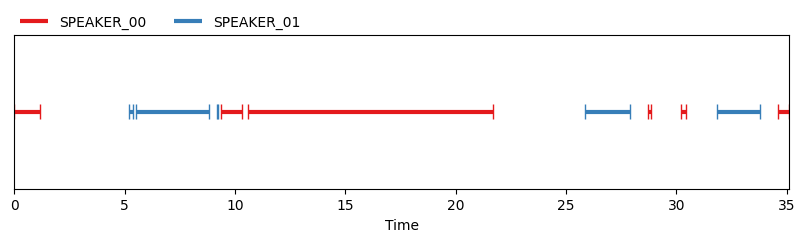

In [20]:
create_annotation_plot(video_output)

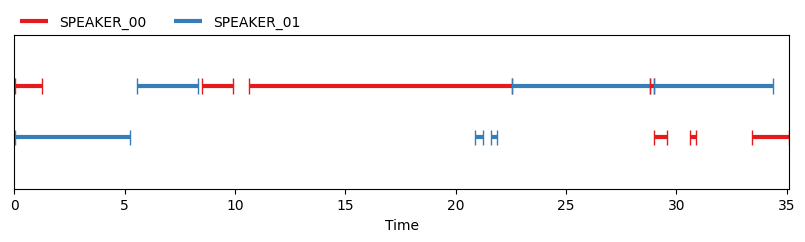

In [21]:
create_annotation_plot(audio_output)

In [22]:
video_audio_mapping = get_video_to_audio_mapping(video_output, audio_output)
video_audio_mapping

{'SPEAKER_00': 'SPEAKER_00', 'SPEAKER_01': 'SPEAKER_01'}

In [23]:
df = generate_openai_transcription(args.videoPath, model)

Transcribe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 38.13/38.13 [00:03<00:00, 11.46sec/s]


In [24]:
df["segment_end"] = df.apply(
    lambda row: (row["segment_end"] + 0.1) if row["segment_start"] == row["segment_end"] else row["segment_end"], axis=1
)
df["word_end"] = df.apply(
    lambda row: (row["word_end"] + 0.1) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
segment_df = df[["segment_id", "segment_text", "segment_start", "segment_end"]].drop_duplicates().reset_index(drop=True)
word_df = df[["segment_id", "word", "word_start", "word_end"]]
segment_df["speaker_output"] = segment_df.apply(
    lambda row: get_segment_to_speaker_mapping(
        row["segment_start"], row["segment_end"], video_audio_mapping, audio_output
    ),
    axis=1,
)
segment_df["speaker_key"] = segment_df["speaker_output"].apply(lambda x: x[0])
segment_df["speaker_confidence"] = segment_df["speaker_output"].apply(lambda x: x[1])

In [25]:
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{row['speaker_key']}: {row['segment_text']}"
    ),
    axis=1
)

In [26]:
# If name mapping known
name_mapping = {"SPEAKER_00": "Trump", "SPEAKER_01": "Piers"}
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{name_mapping[row['speaker_key']]}: {row['segment_text']}"
    ),
    axis=1
)

In [27]:
srt_string = srt.compose(segment_df["Subtitles"].to_list())
with open(os.path.join(args.savePath, args.videoName + datetime.now().strftime("_%Y%m%d_%H%M%S") + ".srt"),
          "w",
         ) as f:
    f.write(srt_string)